In [56]:
#!pip install catboost
#!pip install xgboost

In [308]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import seaborn as sns
from datetime import datetime
#import xgboost as xgb
from catboost import CatBoostRegressor
import os
import warnings
warnings.filterwarnings('ignore')
os.chdir('/Users/kaggle/real-estate-price-prediction-moscow/')

# Loading datasets 

In [309]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [310]:
train_df.shape[1] - 1 == test_df.shape[1]

True

# Target feature distribution and correlations

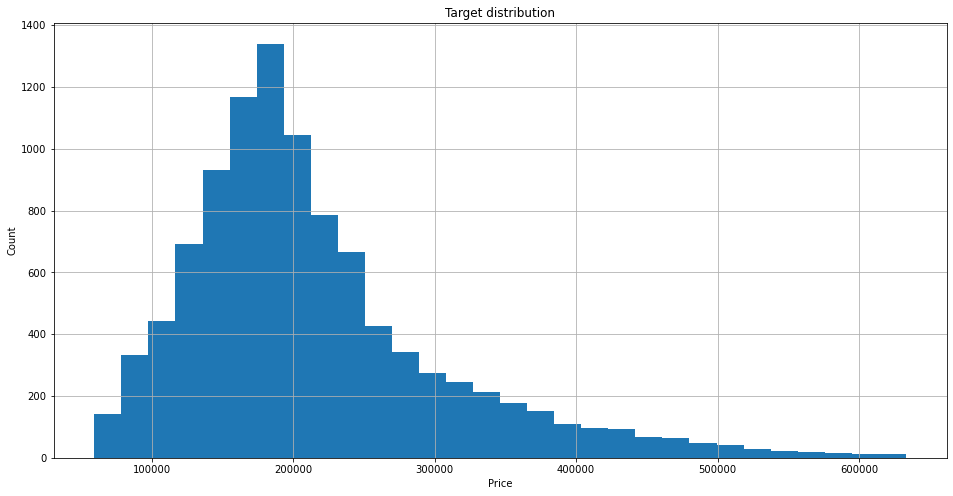

In [311]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

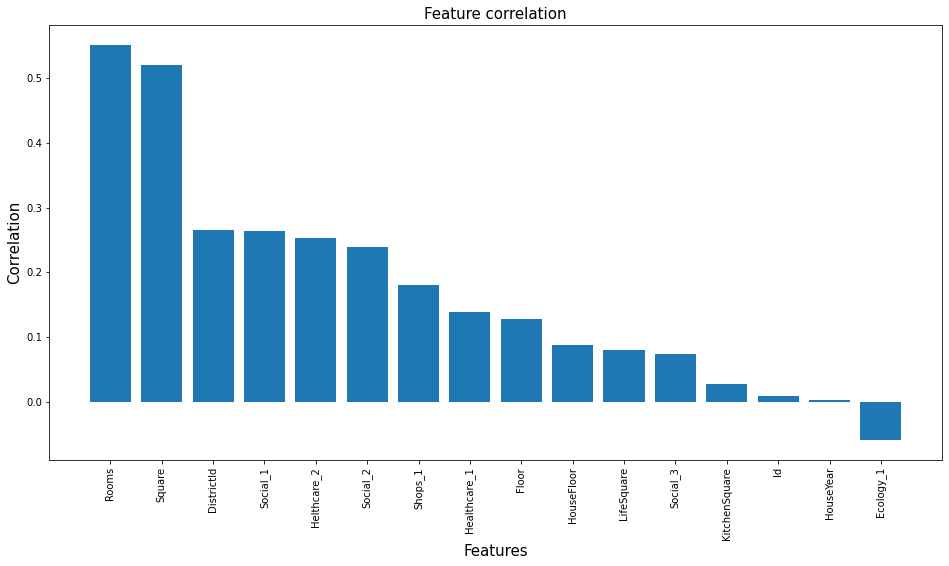

In [312]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

# Data processing and generation of features

In [313]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None

        
    def fit(self, df):
        # Medians and quantiles
        self.medians = df.median() # medians
        
        
    def transform(self, df):        
        # Ecology and Shops switch - object_columns to binary
        object_columns_list = df.select_dtypes(include='object').columns.tolist()
        for name_columns in object_columns_list:
             df.replace({name_columns: {'A': 0, 'B': 1}}, inplace=True)
             df[name_columns].astype('int')
        
        df['Id'] = df['Id'].astype('str')

        df['DistrictId'] = df['DistrictId'].astype('str')
        
        df['Square_outlier'] = 0
        condition = (train_df['Square'] > 300) & (df['Rooms'] <= 5)
        df.loc[condition, 'Square_outlier'] = 1
        df.loc[condition, 'Square'] = (df.loc[condition, 'Square']) / 10
        df.loc[(df['Square'] > 100) | (df['Square'] < 10), 'Square_outlier'] = 1
        df.loc[df['Square'] > 100, 'Square'] = 100
        df.loc[df['Square'] < 10, 'Square'] = 10
        
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        rooms_median = df['Rooms'].median()
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = rooms_median
        
        kitchen_square_median = df['KitchenSquare'].median()
        condition = (df['KitchenSquare'].isna()) \
             | (df['KitchenSquare'] > df['KitchenSquare'].quantile(.95))      
        df.loc[condition, 'KitchenSquare'] = kitchen_square_median
        df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
        condition = df['Floor'] > df['HouseFloor']
        df.loc[condition, 'Floor'] = df.loc[condition, 'HouseFloor']
        df['HouseFloor'] = np.where((df['HouseFloor'] > 57) | (df['HouseFloor'] == 0), df['Floor'], df['HouseFloor'])
        
        current_year = 2020
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1       
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
        df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        condition = (df['LifeSquare'].isna()) \
             & (~df['Square'].isna()) \
             & (~df['KitchenSquare'].isna())
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] \
                                            - df.loc[condition, 'KitchenSquare'] - 3
        
        df['Healthcare_1'].fillna(0, inplace=True)
        
        return df

In [314]:
class FeatureGenerator:
    def __init__(self, large_district_threshold=100):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_square = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
        self.large_district_threshold = large_district_threshold 
        
    def fit(self, X, y=None):
        X = X.copy()

        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
  
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()

            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.square_to_cat(df)

            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()

            self.med_price_by_square = df.groupby(['square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
            self.med_price_by_square_median = self.med_price_by_square['MedPriceBySquare'].median()

    def transform(self, X):
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > self.large_district_threshold).astype(int)

        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        X = self.square_to_cat(X)
        
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['square_cat'], how='left')
            X['MedPriceBySquare'].fillna(self.med_price_by_square_median, inplace=True)

        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
    
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

    def square_to_cat(self, X):
        bins = [X['Square'].min(), 40, 50, 60, 70, 80, X['Square'].max()]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
        X['square_cat'].fillna(-1, inplace=True)
        return X

Data preprocessing

In [315]:
target_name = 'Price'
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [316]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [317]:
preprocessor = DataPreprocessor()
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((8000, 24), (2000, 24))

Feature generation

In [318]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)

X_train.shape, X_valid.shape

((8000, 33), (2000, 33))

In [319]:
test_df = preprocessor.transform(test_df)
test_df = features_gen.transform(test_df)

In [320]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,square_cat,MedPriceByDistrict,MedPriceByFloorYear,MedPriceBySquare
0,4567,44,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,...,0,86.0,0,0,1.0,2.0,0.0,206400.446460,186093.107217,159410.576066
1,5925,62,1.0,42.493907,42.568133,10.0,7.0,17.0,2017,0.072158,...,0,193.0,0,1,2.0,5.0,1.0,162537.996292,179986.169695,173628.298019
2,960,27,2.0,59.463678,47.463678,9.0,19.0,19.0,1977,0.211401,...,1,691.0,0,1,4.0,2.0,2.0,146652.390009,174137.278013,220581.439146
3,3848,23,3.0,49.646030,33.893825,3.0,2.0,2.0,1965,0.014073,...,0,444.0,0,1,0.0,2.0,1.0,113919.670183,182128.021554,173628.298019
4,746,74,1.0,53.837056,49.837056,1.0,8.0,17.0,1977,0.309479,...,1,81.0,0,0,2.0,2.0,2.0,212801.122972,190891.093552,220581.439146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,5.0,5.0,1962,0.069660,...,0,69.0,0,0,1.0,2.0,1.0,173315.200160,186093.107217,173628.298019
4996,16138,38,3.0,93.698122,94.521465,10.0,21.0,27.0,2018,0.060753,...,0,29.0,0,0,4.0,5.0,5.0,317697.404029,195066.700021,296165.936689
4997,3912,101,1.0,33.656723,19.003259,3.0,2.0,5.0,1966,0.038693,...,0,70.0,0,0,0.0,2.0,0.0,187448.635642,182128.021554,159410.576066
4998,5722,10,1.0,38.635155,20.976257,9.0,8.0,14.0,1970,0.089040,...,0,46.0,0,0,2.0,2.0,0.0,217749.656911,190891.093552,159410.576066


In [321]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


Dataset split

In [322]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(222)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.9504
Test R2:	0.777


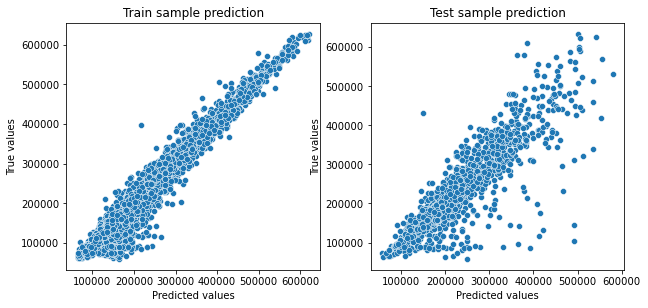

In [323]:
cb_model = CatBoostRegressor(
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=3,
    iterations=2500,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=21,
    silent=True,
)
cb_model.fit(X_train, y_train)

y_train_preds = cb_model.predict(X_train)
y_valid_preds = cb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [324]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [325]:
predictions = cb_model.predict(test_df)
predictions

array([167859.75535538, 124387.66639801, 151724.29767222, ...,
       148510.16187105, 196394.85343991, 271492.91604585])

In [326]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,167859.755355
1,5925,124387.666398
2,960,151724.297672
3,3848,106156.498733
4,746,182314.977737


In [327]:
submit.shape

(5000, 2)

In [328]:
submit.to_csv('сb_submit.csv', index=False)